In [58]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import math
from sklearn.metrics import mean_absolute_error
import datetime


In [19]:
data_train_file = './train.csv'
data_test_file = './test.csv'

df_train = pd.read_csv(data_train_file)
df_test = pd.read_csv(data_test_file)

In [20]:
df_train.shape

(1460, 81)

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Observed most significant integer type columns for SalePrice

1. TotRmsAbvGrd, 
2. BedroomAbvGr, 
3. KitchenAbvGr, 
4. GrLivArea, 
5. YearBuilt, 
6. YearRemodAdd--Remodeled date, 
7. OverallQual
8. OverallCond

Personal thought: 

In most cases of our society, Houses located near downtown must be more valuable. If we mark the distance between houses and downtown on our dataset it could indicate the house price somehow efficiently. 

<AxesSubplot:title={'center':'SalePrice X TotRmsAbvGrd'}, xlabel='TotRmsAbvGrd', ylabel='SalePrice'>

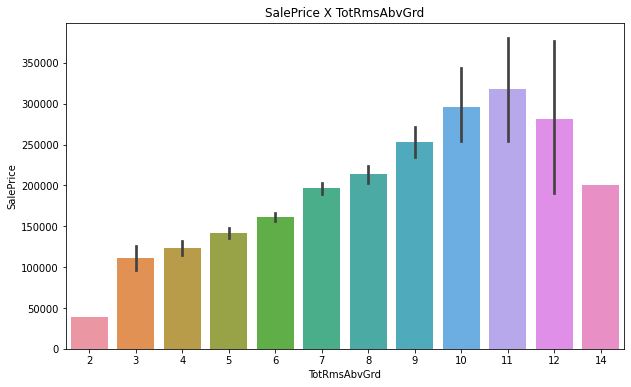

In [40]:
#lets see the relation between SalePrice and TotalRooms
plt.figure(figsize=(10,6))
plt.title("SalePrice X TotRmsAbvGrd")
sns.barplot(x=df_train.TotRmsAbvGrd, y=df_train["SalePrice"])

However there is some kind of linear pattern, houses with higher than 11 rooms tend to be less valuable

Let's explore Total Rooms more

In [54]:
#Let's group houses with Total Rooms and see density of houses grouped 
    #by Total Rooms, minimum, maximum prices
byTotalRooms = df_train.groupby(["TotRmsAbvGrd"]).SalePrice.agg([len, min, max])

In [52]:
byTotalRooms

,len,min,max
TotRmsAbvGrd,,,
3,18,39300,155900
4,97,34900,260000
5,275,52000,392500
6,402,37900,374000
7,329,55000,465000
8,187,81000,466500
9,75,98000,501837
10,47,90000,755000
11,18,106000,611657


There only 1 house with 2 rooms and 14 rooms.

Let's round houses with 2 and 14 rooms with it's neighbor to make our graph more linear.

In [50]:
df_train["TotRmsAbvGrd"]=df_train["TotRmsAbvGrd"].replace([14], 12)
df_train["TotRmsAbvGrd"]=df_train["TotRmsAbvGrd"].replace([2], 3)

In [55]:
byTotalRooms = df_train.groupby(["TotRmsAbvGrd"]).SalePrice.agg([len, min, max])
byTotalRooms

,len,min,max
TotRmsAbvGrd,,,
3,18,39300,155900
4,97,34900,260000
5,275,52000,392500
6,402,37900,374000
7,329,55000,465000
8,187,81000,466500
9,75,98000,501837
10,47,90000,755000
11,18,106000,611657


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

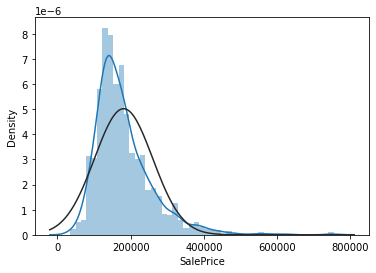

In [39]:
#Let's see the distribution of House SalePrices
sns.distplot(df_train["SalePrice"], fit=norm)

If the house is remodeled more recently it's value must increase. So let's modify the column YearRemodAdd

In [63]:
df_train["YearRemodAdd"] = datetime.datetime.now().year - df_train["YearRemodAdd"]


Let's observe the correlations between numerical variables

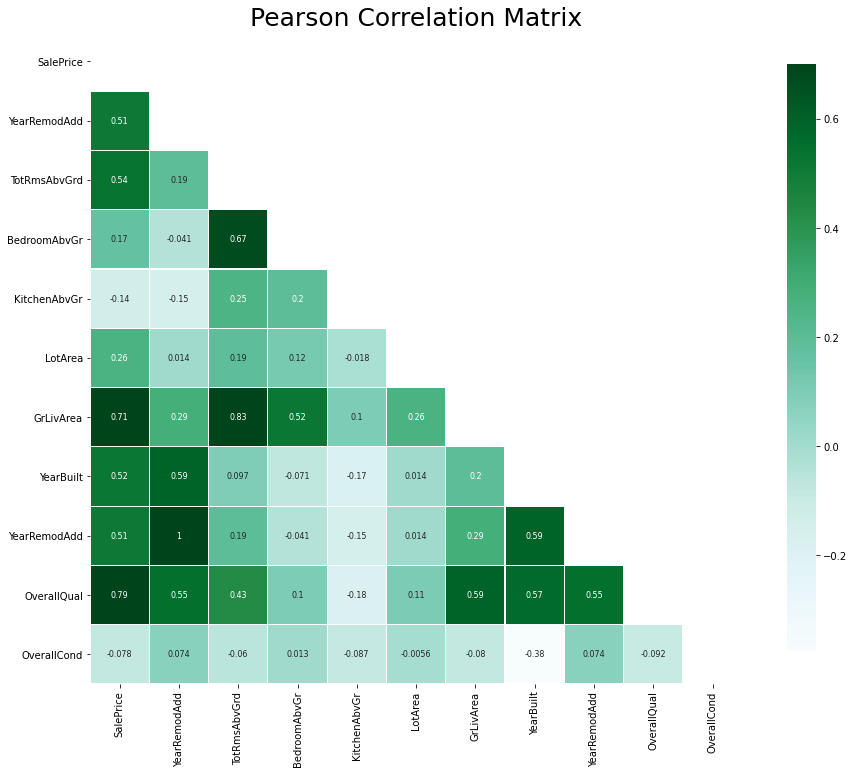

In [67]:
features = ["SalePrice",'YearRemodAdd','TotRmsAbvGrd', 'BedroomAbvGr', 'KitchenAbvGr', 'LotArea',
       'GrLivArea', 'YearBuilt', 'YearRemodAdd', 'OverallQual', 'OverallCond',
       ]
mask = np.zeros_like(df_train[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df_train[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

We see that SalePrice has strong relationships with 

YearRemodAdd, 
TotRmsAbvGrd, 
GrLivArea, 
YearBuilt, 
YearRemodAdd, 
OverallQual

But we must consider features that correlated with saleprice but not strongly correlated with each other. 

1. BedroomAbvGr
2. LotArea
3. OverallQual
4. KitchenAbvGr


In [125]:
X = df_train.loc[:, ["BedroomAbvGr", "LotArea", "OverallQual", "KitchenAbvGr"]]
y = df_train.loc[:, ["SalePrice"]]


In [121]:
# separate y and X into train and test
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42
                                                   )

In [123]:
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())


                                 OLS Regression Results                                
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.942
Model:                            OLS   Adj. R-squared (uncentered):              0.941
Method:                 Least Squares   F-statistic:                              4103.
Date:                Tue, 27 Oct 2020   Prob (F-statistic):                        0.00
Time:                        16:04:49   Log-Likelihood:                         -12459.
No. Observations:                1022   AIC:                                  2.493e+04
Df Residuals:                    1018   BIC:                                  2.495e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [127]:
#Let's predict the test data

lr = LinearRegression()
lr.fit(X, y)
test_pre = lr.predict(X_test)
train_pre = lr.predict(X_train)


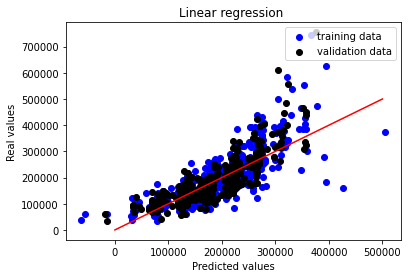

In [143]:
plt.scatter(train_pre, y_train, c="blue", label = "training data")
plt.scatter(test_pre, y_test, c = "black", label="validation data")
plt.title("Linear regression ")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc="upper right")
plt.plot([0,500000], [0,500000], c="red")
plt.show()

In [112]:
#get the results from the regression in dataframe format
res = pd.DataFrame(data=train_pre, columns=['predicted values'])
#join with the actual prices
res = y_train.reset_index().join(res)
#join with the training dataset
resfin = res.join(X_train, on='index',lsuffix='_y')
# compute the actual prices, predicted prices and error
resfin['predprice']=res['predicted values']
resfin['actprice']=res['SalePrice']
resfin['error']=resfin['predprice']-resfin['actprice']

In [114]:
#get the results from the regression in dataframe format
res_test = pd.DataFrame(data=test_pre, columns=['predicted values'])
#join with the actual prices
res_test = y_test.reset_index().join(res_test)
#join with the training dataset
resfin_test = res_test.join(X_test, on='index',lsuffix='_y')
# compute the actual prices, predicted prices and error
resfin_test['predprice']=resfin_test['predicted values']
resfin_test['actprice']=resfin_test['SalePrice']
resfin_test['error']=resfin_test['predprice']-resfin_test['actprice']
resdf = pd.concat([resfin,resfin_test])

In [115]:
"The mean error of our model is ${:,.0f}".format(resfin_test['error'].mean())

'The mean error of our model is $-4,359'

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='error', ylabel='Density'>

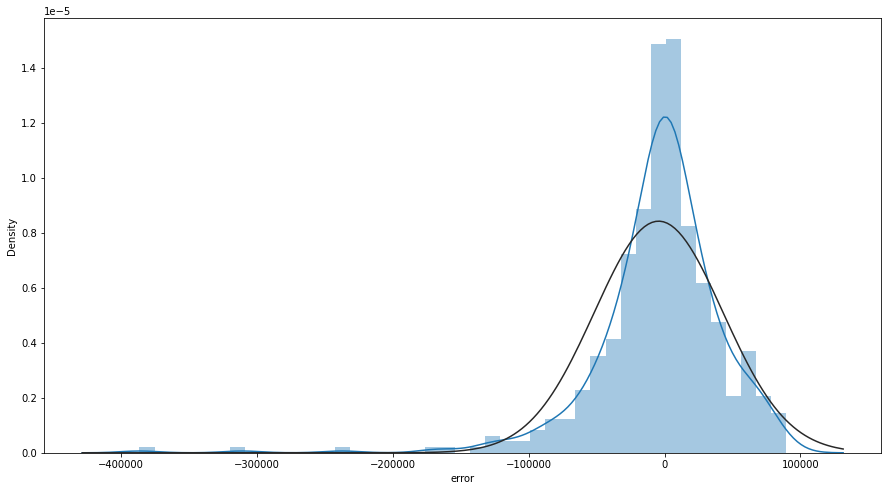

In [116]:
#plot the error
plt.figure(figsize=(15,8))
sns.distplot(resfin_test['error'], fit=norm)

In [141]:
#Lets produce the submission csv file 
#Let's predict the test data
X_test_df = df_test.loc[:, ["BedroomAbvGr", "LotArea", "OverallQual", "KitchenAbvGr"]]
predicted = lr.predict(X_test_df).flatten()
predicted = pd.DataFrame({"SalePrice": predicted}, columns=["SalePrice"])
predicted.index.name = "Id"
predicted.index+=1461
predicted.to_csv(r'~/Desktop/HousePrediction/predicted.csv', index = True, header=True)
predicted

,SalePrice
Id,
1461,128325.316614
1462,182796.460852
1463,138295.498100
1464,176843.286270
1465,250824.062160
...,...
2915,77892.105599
2916,77833.809182
2917,153764.974922
